# Week 12 Day 1: Requested topic: Fitting

## Objectives:
* Cover performance and syntax for general unbinned fitting.

Remember to `pip install probfit` (`--user` if you are not in a virtual environment). `cupy` is used at the end; you'll need `conda install cupy` in an environment. Times are from a 24 core Xeon with a Titan V.

## Make data

First, we make our data. It's a simple double gaussian with no background.

In [1]:
import probfit
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
dist = np.hstack([
    np.random.normal(loc=1, scale=2., size=250_000),
    np.random.normal(loc=1, scale=.5, size=250_000)
])

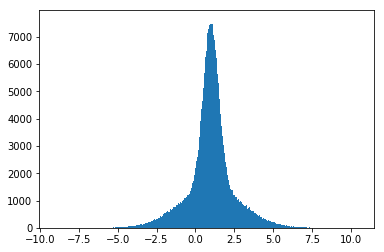

In [3]:
plt.hist(dist, bins='auto');

## Probfit

Now, let's try using probfit to fit the data. First, we have to rename the parameters - probfit merges similar named parameters. I already know that gaussian comes with `x`, `mean`, and `sigma`. We use `AddPdfNorm` to add the pdfs, and they are kept normalized. A new parameter is added, `f_0`.

In [4]:
second_gaussian = probfit.rename(probfit.gaussian, ["x", "mean", "sigma2"])
pdf_function = probfit.AddPdfNorm(probfit.gaussian, second_gaussian)

Now, let's build an unbinned likelyhood function:

In [5]:
unbinned_lh = probfit.UnbinnedLH(pdf_function, dist)

We have to use iMinuit's name based parameter setting interface:

In [6]:
minuit = Minuit(unbinned_lh,
                
                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

And let's do the fit!

In [7]:
%%time
output = minuit.migrad()

FCN = 835549.2121474851 
 TOTAL NCALL = 134 
 NCALLS = 134 
 
 
 EDM = 1.6958291010359605e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mean,0.997861,0.00125253,,,-10,10,No
1,sigma,0.498397,0.00147609,,,0,1,No
2,sigma2,1.99296,0.00362041,,,1,3,No
3,f_0,0.498319,0.00152575,,,0,1,No


CPU times: user 1min 7s, sys: 248 ms, total: 1min 7s
Wall time: 1min 6s


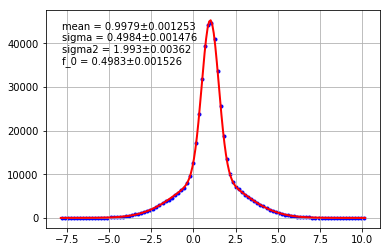

In [8]:
unbinned_lh.draw(minuit);

## GooFit

Let's try that in GooFit. We set up our model in what I view as a more readable but more verbose way:

In [9]:
import goofit

In [10]:
goofit.GOOFIT_DEVICE

'CUDA'

In [11]:
x = goofit.Observable('x', -10, 10)

ds = goofit.UnbinnedDataSet(x)
ds.from_matrix([dist], filter=True)

mean = goofit.Variable('mean', 1.5, -10, 10)
sigma = goofit.Variable('sigma', .4, 0, 1)
sigma2 = goofit.Variable('sigma2', 3, 1, 3)
f_0 = goofit.Variable('f_0', .5, 0, 1)

gauss1 = goofit.GaussianPdf("gauss1", x, mean, sigma)
gauss2 = goofit.GaussianPdf("gauss2", x, mean, sigma2)

pdf = goofit.AddPdf('pdf', [f_0], [gauss1, gauss2])

pdf.fitTo(ds);

MnSeedGenerator: for initial parameters FCN = 1936947.979758
MnSeedGenerator: Initial state:   - FCN =   1936947.979758 Edm =       374900 NCalls =     19
MnSeedGenerator: Negative G2 found - new state:   - FCN =   1869258.114207 Edm =       363093 NCalls =     42
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   1869258.114207 Edm =       363093 NCalls =     42
VariableMetric: Iteration #   0 - FCN =   1869258.114207 Edm =       363093 NCalls =     42
VariableMetric: Iteration #   1 - FCN =   1680051.612549 Edm =      9387.14 NCalls =     54
VariableMetric: Iteration #   2 - FCN =   1674111.566517 Edm =      2298.16 NCalls =     64
VariableMetric: Iteration #   3 - FCN =   1671353.960358 Edm =      296.322 NCalls =     74
VariableMetric: Iteration #   4 - FCN =   1671106.899882 Edm =      8.17224 NCalls =     84
VariableMetric: Iteration #   5 - FCN =   1671073.819546 Edm =      1.26946 NCalls =     94
VariableMetric: Iteration #   6 - FCN

> Note: On a single thread CPU build, this is about 7-10x faster than probfit. This is on a Titan V GPU, so it's a lot more than that.

Plotting is a bit more verbose, but not too bad:

In [12]:
grid, points = pdf.evaluatePdf(x)
xs = grid.to_matrix().flatten()

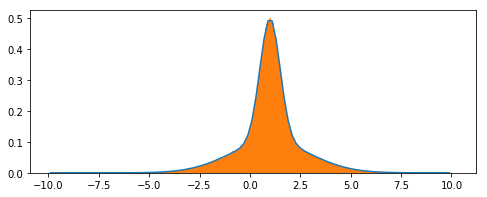

In [13]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xs, points)
ax.hist(dist, bins='auto', density=True)
plt.show()

## Numpy

Let's try this with Numpy and iMinuit. We could use probfit to make the NLL, but it's much faster to do it ourselves.

#### Note:
I originally used numba here, but since this is all done in array form, even parallel Numba is only a small fraction (10-30%) faster on my laptop. On a 24 core Xeon, however... You'll see.

In [14]:
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [15]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [16]:
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [17]:
nll(.5,.5,.5,.5)

2475177.694243533

In [18]:
%%timeit
nll(.5,.5,.5,.5)

5.3 ms ± 46.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [20]:
%%time
output = minuit.migrad()

FCN = 835549.2121305898 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 6.314759644330805e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.498322,0.00215772,,,0,1,No
1,mean,0.997863,0.00177133,,,-10,10,No
2,sigma,0.498395,0.00208748,,,0,1,No
3,sigma2,1.99295,0.00511992,,,1,3,No


CPU times: user 24 s, sys: 874 ms, total: 24.9 s
Wall time: 1.04 s


In [21]:
# Much (2-3x) slower if we use this in Minuit
unbinned_lh = probfit.UnbinnedLH(add, dist)

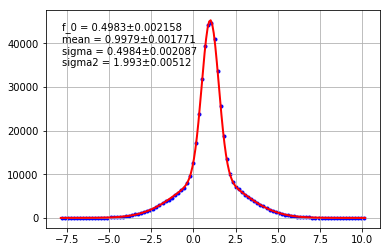

In [22]:
unbinned_lh.draw(minuit);

## Numba

Let's use Numba's parallel abilities:

In [23]:
import numba

@numba.njit(parallel=True)
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [24]:
@numba.njit(parallel=True)
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [25]:
@numba.njit(parallel=True)
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [26]:
nll(.5,.5,.5,.5)

2475177.6942435335

In [27]:
%%timeit
nll(.5,.5,.5,.5)

1.96 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [29]:
%%time
output = minuit.migrad()

FCN = 835549.2121305895 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 6.313862300803665e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.498322,0.00215772,,,0,1,No
1,mean,0.997863,0.00177133,,,-10,10,No
2,sigma,0.498395,0.00208748,,,0,1,No
3,sigma2,1.99295,0.00511992,,,1,3,No


CPU times: user 12.7 s, sys: 235 ms, total: 12.9 s
Wall time: 271 ms


In [30]:
# Much (2-3x) slower if we use this in Minuit
unbinned_lh = probfit.UnbinnedLH(add, dist)

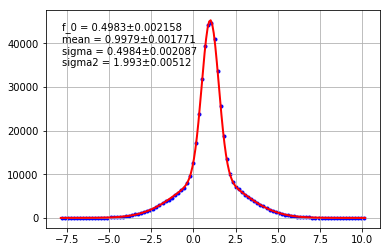

In [31]:
unbinned_lh.draw(minuit);

## CUPY GPU

Let's use CUPY on the GPU:

In [4]:
import cupy

In [5]:
%%time
d_dist = cupy.array(dist)

CPU times: user 237 ms, sys: 526 ms, total: 763 ms
Wall time: 683 ms


In [6]:
def gaussian(x, μ, σ):
    return 1/cupy.sqrt(2*np.pi*σ**2) * cupy.exp(-(x-μ)**2/(2*σ**2))

In [7]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [21]:
def nll(f_0, mean, sigma, sigma2):
    return -cupy.sum(cupy.log(add(d_dist, f_0, mean, sigma, sigma2)))

In [28]:
mykernel = cupy.ElementwiseKernel(
    'float64 x, float64 f_0, float64 mean, float64 sigma, float64 sigma2',
    'float64 z', '''
    
    double g = 1/sqrt(2*sigma*sigma) * exp(-(x-mean)*(x-mean)/(2*sigma*sigma));
    double g2 = 1/sqrt(2*sigma2*sigma2) * exp(-(x-mean)*(x-mean)/(2*sigma2*sigma2));
    
    double v = f_0 * g + (1 - f_0) * g2;
    
    z = log(v);
    ''', 'mykernel')

In [29]:
def nll2(f_0, mean, sigma, sigma2):
    return -cupy.sum(mykernel(d_dist, f_0, mean, sigma, sigma2))

In [30]:
%%timeit
nll(.5,.5,.5,.5)

642 µs ± 9.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
%%timeit
nll2(.5,.5,.5,.5)

100 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [37]:
%%time
output = minuit.migrad()

FCN = 835788.3264581227 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 5.398256318847866e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.500175,0.00215934,,,0,1,No
1,mean,0.998307,0.00177379,,,-10,10,No
2,sigma,0.500402,0.00209158,,,0,1,No
3,sigma2,1.99772,0.00514593,,,1,3,No


CPU times: user 186 ms, sys: 19 ms, total: 205 ms
Wall time: 194 ms


In [38]:
minuit = Minuit(nll2,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


In [39]:
%%time
output = minuit.migrad()

FCN = 549605.8549958239 
 TOTAL NCALL = 137 
 NCALLS = 137 
 
 
 EDM = 1.0481080081916944e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.500175,0.00215974,,,0,1,No
1,mean,0.998307,0.00177379,,,-10,10,No
2,sigma,0.500402,0.00209188,,,0,1,No
3,sigma2,1.99773,0.00514665,,,1,3,No


CPU times: user 62.2 ms, sys: 15 ms, total: 77.2 ms
Wall time: 75.5 ms
